In [1]:
import numpy as np
import sys
import os
sys.path.append('../')

# Mayer-f function average for gaussian patch interaction

In [2]:
from scipy import integrate

In [3]:
#calculate the average mayer function for werthim theory
#between off-centered the patch on a particle and the centered
#patch on another particle using a lammps-style gaussian interaction
def Favg(r, rdis, A, B, rcut):  
    
    #place polymer end along the z axis
    polymer_end = np.array([0, 0, r])
    
    #interaction potential
    def SinFpp(theta, phi):
        
        patch = np.array([np.sin(theta)*np.cos(phi),
                          np.sin(theta)*np.sin(phi), 
                          np.cos(theta)])
        patch = patch*rdis
        rpp = np.linalg.norm(polymer_end - patch)
        upp = -A*np.exp(-B*rpp**2)*np.heaviside(rcut - rpp, 0)
        fpp = np.exp(-upp) - 1.0
        
        return np.sin(theta)*fpp
    
    #perform the 2D integration
    integral = integrate.dblquad(SinFpp, 0, 2.0*np.pi, lambda phi: 0, lambda phi: np.pi)
    average = integral[0] / (4.0*np.pi)
    
    return average

### Parameters

In [3]:
dp = 1.0
dc = 5.0

Amin = 0.0
Amax = 20.0
Ainc = 0.1
B = 1.0/0.2**2

rdis = dp*2.0**(1.0/6.0) + (dp + dc)/2.0 - dp
rcut = 0.5*dp
rmin = rdis - rcut*1.1
rmax = rdis + rcut*1.1

dr = 0.005
rs = np.arange(rmin, rmax, dr)
As = np.arange(Amin, Amax, Ainc)

In [4]:
path = './favg__dp={}__dc={}__B={}__rdis={}__rcut={}'.format(dp, dc, B, rdis, rcut)
if not os.path.exists(path):
    os.makedirs(path)

### Generate, save and model the average mayer-f function

In [ ]:
for A in As:
    print "Working on A={}".format(A)
    
    data = [A]
    for r in rs:
        data.append(Favg(r, rdis, A, B, rcut))
    
    #convert to an array and save
    data = np.array(data)
    np.savetxt('{}/A={}.txt'.format(path, A), data)

### Read in the data and create ML model

In [6]:
data = []
for filename in os.listdir(path):
    if filename.endswith(".txt"):
        data.append(np.loadtxt('{}/{}'.format(path, filename)))
    else:
        continue
data = np.array(data)

### Build analytical bond volume NN model for given interactions

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
r_scaler = StandardScaler()
A_scaler = StandardScaler()

In [9]:
rs_norm = rs[11:-10]
rs_norm = np.transpose(r_scaler.fit_transform(np.transpose(np.array([rs_norm]))))[0]

In [10]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

In [11]:
#attraction strength
x = data[:,0:1] 
scaler_x.fit(x)
x = scaler_x.transform(x)

#average mayer-f as a function of r
y = data[:,1:]
y = y[:,11:-10]
y = np.log(1.0+y)     

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

In [14]:
from regression.code.functional_fit_helper import FunctionalFitHelper
from keras.callbacks import ModelCheckpoint

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [15]:
# Save the checkpoint in the /output folder
filepath = "{}/model.hdf5".format(path)

In [16]:
# Keep only a single checkpoint, the best over test accuracy.
checkpoint = ModelCheckpoint(filepath,
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')

In [15]:
functional_helper = FunctionalFitHelper()

In [16]:
functional_helper.InitializeNewModel(x.shape[1], num_cnts=5, 
                                     hidden_dim_rbf=20, activation_rbf='relu',
                                     hidden_dim_mod=None, activation_mod='relu')

In [17]:
model = functional_helper.BuildModel(rs_norm)

In [18]:
model.compile(loss='mean_squared_error', optimizer='adamax')

In [19]:
# Train neural network
history = model.fit(x_train, # Features
                    y_train, # Target vector
                    epochs=10000, # Number of epochs
                    verbose=1, # No output
                    batch_size=1000, # Number of observations per batch
                    validation_data=(x_test, y_test))#,
                    #callbacks=[checkpoint]) # Data for evaluation

Train on 900 samples, validate on 100 samples
Epoch 1/10000
900/900 [==============================] - 0s - loss: 2.6771 - val_loss: 3.1027
Epoch 2/10000
900/900 [==============================] - 0s - loss: 2.5811 - val_loss: 3.0142
Epoch 3/10000
900/900 [==============================] - 0s - loss: 2.4958 - val_loss: 2.9337
Epoch 4/10000
900/900 [==============================] - 0s - loss: 2.4192 - val_loss: 2.8604
Epoch 5/10000
900/900 [==============================] - 0s - loss: 2.3502 - val_loss: 2.7932
Epoch 6/10000
900/900 [==============================] - 0s - loss: 2.2877 - val_loss: 2.7315
Epoch 7/10000
900/900 [==============================] - 0s - loss: 2.2309 - val_loss: 2.6745
Epoch 8/10000
900/900 [==============================] - 0s - loss: 2.1792 - val_loss: 2.6217
Epoch 9/10000
900/900 [==============================] - 0s - loss: 2.1318 - val_loss: 2.5728
Epoch 10/10000
900/900 [==============================] - 0s - loss: 2.0884 - val_loss: 2.5274
Epoch 11/1000

900/900 [==============================] - 0s - loss: 0.9038 - val_loss: 1.0726
Epoch 87/10000
900/900 [==============================] - 0s - loss: 0.8937 - val_loss: 1.0600
Epoch 88/10000
900/900 [==============================] - 0s - loss: 0.8838 - val_loss: 1.0475
Epoch 89/10000
900/900 [==============================] - 0s - loss: 0.8739 - val_loss: 1.0351
Epoch 90/10000
900/900 [==============================] - 0s - loss: 0.8641 - val_loss: 1.0229
Epoch 91/10000
900/900 [==============================] - 0s - loss: 0.8543 - val_loss: 1.0107
Epoch 92/10000
900/900 [==============================] - 0s - loss: 0.8447 - val_loss: 0.9987
Epoch 93/10000
900/900 [==============================] - 0s - loss: 0.8352 - val_loss: 0.9868
Epoch 94/10000
900/900 [==============================] - 0s - loss: 0.8257 - val_loss: 0.9750
Epoch 95/10000
900/900 [==============================] - 0s - loss: 0.8163 - val_loss: 0.9633
Epoch 96/10000
900/900 [==============================] - 0s - lo

900/900 [==============================] - 0s - loss: 0.3344 - val_loss: 0.3754
Epoch 172/10000
900/900 [==============================] - 0s - loss: 0.3306 - val_loss: 0.3710
Epoch 173/10000
900/900 [==============================] - 0s - loss: 0.3268 - val_loss: 0.3666
Epoch 174/10000
900/900 [==============================] - 0s - loss: 0.3231 - val_loss: 0.3622
Epoch 175/10000
900/900 [==============================] - 0s - loss: 0.3195 - val_loss: 0.3579
Epoch 176/10000
900/900 [==============================] - 0s - loss: 0.3159 - val_loss: 0.3537
Epoch 177/10000
900/900 [==============================] - 0s - loss: 0.3123 - val_loss: 0.3495
Epoch 178/10000
900/900 [==============================] - 0s - loss: 0.3088 - val_loss: 0.3454
Epoch 179/10000
900/900 [==============================] - 0s - loss: 0.3053 - val_loss: 0.3414
Epoch 180/10000
900/900 [==============================] - 0s - loss: 0.3019 - val_loss: 0.3374
Epoch 181/10000
900/900 [==============================]

900/900 [==============================] - 0s - loss: 0.1428 - val_loss: 0.1571
Epoch 257/10000
900/900 [==============================] - 0s - loss: 0.1417 - val_loss: 0.1558
Epoch 258/10000
900/900 [==============================] - 0s - loss: 0.1405 - val_loss: 0.1545
Epoch 259/10000
900/900 [==============================] - 0s - loss: 0.1394 - val_loss: 0.1533
Epoch 260/10000
900/900 [==============================] - 0s - loss: 0.1382 - val_loss: 0.1521
Epoch 261/10000
900/900 [==============================] - 0s - loss: 0.1371 - val_loss: 0.1509
Epoch 262/10000
900/900 [==============================] - 0s - loss: 0.1360 - val_loss: 0.1497
Epoch 263/10000
900/900 [==============================] - 0s - loss: 0.1350 - val_loss: 0.1486
Epoch 264/10000
900/900 [==============================] - 0s - loss: 0.1339 - val_loss: 0.1474
Epoch 265/10000
900/900 [==============================] - 0s - loss: 0.1328 - val_loss: 0.1463
Epoch 266/10000
900/900 [==============================]

900/900 [==============================] - 0s - loss: 0.0829 - val_loss: 0.0948
Epoch 342/10000
900/900 [==============================] - 0s - loss: 0.0826 - val_loss: 0.0944
Epoch 343/10000
900/900 [==============================] - 0s - loss: 0.0822 - val_loss: 0.0941
Epoch 344/10000
900/900 [==============================] - 0s - loss: 0.0818 - val_loss: 0.0937
Epoch 345/10000
900/900 [==============================] - 0s - loss: 0.0814 - val_loss: 0.0933
Epoch 346/10000
900/900 [==============================] - 0s - loss: 0.0811 - val_loss: 0.0930
Epoch 347/10000
900/900 [==============================] - 0s - loss: 0.0807 - val_loss: 0.0926
Epoch 348/10000
900/900 [==============================] - 0s - loss: 0.0804 - val_loss: 0.0923
Epoch 349/10000
900/900 [==============================] - 0s - loss: 0.0800 - val_loss: 0.0919
Epoch 350/10000
900/900 [==============================] - 0s - loss: 0.0797 - val_loss: 0.0916
Epoch 351/10000
900/900 [==============================]

900/900 [==============================] - 0s - loss: 0.0622 - val_loss: 0.0749
Epoch 427/10000
900/900 [==============================] - 0s - loss: 0.0621 - val_loss: 0.0747
Epoch 428/10000
900/900 [==============================] - 0s - loss: 0.0619 - val_loss: 0.0745
Epoch 429/10000
900/900 [==============================] - 0s - loss: 0.0618 - val_loss: 0.0744
Epoch 430/10000
900/900 [==============================] - 0s - loss: 0.0616 - val_loss: 0.0742
Epoch 431/10000
900/900 [==============================] - 0s - loss: 0.0615 - val_loss: 0.0740
Epoch 432/10000
900/900 [==============================] - 0s - loss: 0.0613 - val_loss: 0.0738
Epoch 433/10000
900/900 [==============================] - 0s - loss: 0.0612 - val_loss: 0.0735
Epoch 434/10000
900/900 [==============================] - 0s - loss: 0.0610 - val_loss: 0.0733
Epoch 435/10000
900/900 [==============================] - 0s - loss: 0.0608 - val_loss: 0.0731
Epoch 436/10000
900/900 [==============================]

900/900 [==============================] - 0s - loss: 0.0498 - val_loss: 0.0590
Epoch 512/10000
900/900 [==============================] - 0s - loss: 0.0497 - val_loss: 0.0588
Epoch 513/10000
900/900 [==============================] - 0s - loss: 0.0496 - val_loss: 0.0587
Epoch 514/10000
900/900 [==============================] - 0s - loss: 0.0494 - val_loss: 0.0585
Epoch 515/10000
900/900 [==============================] - 0s - loss: 0.0493 - val_loss: 0.0583
Epoch 516/10000
900/900 [==============================] - 0s - loss: 0.0492 - val_loss: 0.0582
Epoch 517/10000
900/900 [==============================] - 0s - loss: 0.0490 - val_loss: 0.0580
Epoch 518/10000
900/900 [==============================] - 0s - loss: 0.0489 - val_loss: 0.0579
Epoch 519/10000
900/900 [==============================] - 0s - loss: 0.0488 - val_loss: 0.0577
Epoch 520/10000
900/900 [==============================] - 0s - loss: 0.0487 - val_loss: 0.0575
Epoch 521/10000
900/900 [==============================]

900/900 [==============================] - 0s - loss: 0.0403 - val_loss: 0.0476
Epoch 597/10000
900/900 [==============================] - 0s - loss: 0.0402 - val_loss: 0.0475
Epoch 598/10000
900/900 [==============================] - 0s - loss: 0.0401 - val_loss: 0.0474
Epoch 599/10000
900/900 [==============================] - 0s - loss: 0.0400 - val_loss: 0.0473
Epoch 600/10000
900/900 [==============================] - 0s - loss: 0.0399 - val_loss: 0.0471
Epoch 601/10000
900/900 [==============================] - 0s - loss: 0.0398 - val_loss: 0.0470
Epoch 602/10000
900/900 [==============================] - 0s - loss: 0.0397 - val_loss: 0.0469
Epoch 603/10000
900/900 [==============================] - 0s - loss: 0.0397 - val_loss: 0.0468
Epoch 604/10000
900/900 [==============================] - 0s - loss: 0.0396 - val_loss: 0.0467
Epoch 605/10000
900/900 [==============================] - 0s - loss: 0.0395 - val_loss: 0.0466
Epoch 606/10000
900/900 [==============================]

900/900 [==============================] - 0s - loss: 0.0335 - val_loss: 0.0396
Epoch 682/10000
900/900 [==============================] - 0s - loss: 0.0334 - val_loss: 0.0395
Epoch 683/10000
900/900 [==============================] - 0s - loss: 0.0333 - val_loss: 0.0394
Epoch 684/10000
900/900 [==============================] - 0s - loss: 0.0333 - val_loss: 0.0393
Epoch 685/10000
900/900 [==============================] - 0s - loss: 0.0332 - val_loss: 0.0393
Epoch 686/10000
900/900 [==============================] - 0s - loss: 0.0331 - val_loss: 0.0392
Epoch 687/10000
900/900 [==============================] - 0s - loss: 0.0331 - val_loss: 0.0391
Epoch 688/10000
900/900 [==============================] - 0s - loss: 0.0330 - val_loss: 0.0390
Epoch 689/10000
900/900 [==============================] - 0s - loss: 0.0329 - val_loss: 0.0389
Epoch 690/10000
900/900 [==============================] - 0s - loss: 0.0328 - val_loss: 0.0389
Epoch 691/10000
900/900 [==============================]

900/900 [==============================] - 0s - loss: 0.0282 - val_loss: 0.0333
Epoch 767/10000
900/900 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0332
Epoch 768/10000
900/900 [==============================] - 0s - loss: 0.0281 - val_loss: 0.0331
Epoch 769/10000
900/900 [==============================] - 0s - loss: 0.0280 - val_loss: 0.0331
Epoch 770/10000
900/900 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0330
Epoch 771/10000
900/900 [==============================] - 0s - loss: 0.0279 - val_loss: 0.0329
Epoch 772/10000
900/900 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0329
Epoch 773/10000
900/900 [==============================] - 0s - loss: 0.0278 - val_loss: 0.0328
Epoch 774/10000
900/900 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0328
Epoch 775/10000
900/900 [==============================] - 0s - loss: 0.0277 - val_loss: 0.0327
Epoch 776/10000
900/900 [==============================]

900/900 [==============================] - 0s - loss: 0.0239 - val_loss: 0.0281
Epoch 852/10000
900/900 [==============================] - 0s - loss: 0.0238 - val_loss: 0.0281
Epoch 853/10000
900/900 [==============================] - 0s - loss: 0.0238 - val_loss: 0.0280
Epoch 854/10000
900/900 [==============================] - 0s - loss: 0.0237 - val_loss: 0.0279
Epoch 855/10000
900/900 [==============================] - 0s - loss: 0.0237 - val_loss: 0.0279
Epoch 856/10000
900/900 [==============================] - 0s - loss: 0.0236 - val_loss: 0.0278
Epoch 857/10000
900/900 [==============================] - 0s - loss: 0.0236 - val_loss: 0.0278
Epoch 858/10000
900/900 [==============================] - 0s - loss: 0.0236 - val_loss: 0.0277
Epoch 859/10000
900/900 [==============================] - 0s - loss: 0.0235 - val_loss: 0.0277
Epoch 860/10000
900/900 [==============================] - 0s - loss: 0.0235 - val_loss: 0.0276
Epoch 861/10000
900/900 [==============================]

900/900 [==============================] - 0s - loss: 0.0203 - val_loss: 0.0239
Epoch 937/10000
900/900 [==============================] - 0s - loss: 0.0203 - val_loss: 0.0239
Epoch 938/10000
900/900 [==============================] - 0s - loss: 0.0202 - val_loss: 0.0238
Epoch 939/10000
900/900 [==============================] - 0s - loss: 0.0202 - val_loss: 0.0238
Epoch 940/10000
900/900 [==============================] - 0s - loss: 0.0202 - val_loss: 0.0237
Epoch 941/10000
900/900 [==============================] - 0s - loss: 0.0201 - val_loss: 0.0237
Epoch 942/10000
900/900 [==============================] - 0s - loss: 0.0201 - val_loss: 0.0237
Epoch 943/10000
900/900 [==============================] - 0s - loss: 0.0200 - val_loss: 0.0236
Epoch 944/10000
900/900 [==============================] - 0s - loss: 0.0200 - val_loss: 0.0236
Epoch 945/10000
900/900 [==============================] - 0s - loss: 0.0200 - val_loss: 0.0235
Epoch 946/10000
900/900 [==============================]

900/900 [==============================] - 0s - loss: 0.0174 - val_loss: 0.0205
Epoch 1022/10000
900/900 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0204
Epoch 1023/10000
900/900 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0204
Epoch 1024/10000
900/900 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0204
Epoch 1025/10000
900/900 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0203
Epoch 1026/10000
900/900 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0203
Epoch 1027/10000
900/900 [==============================] - 0s - loss: 0.0172 - val_loss: 0.0203
Epoch 1028/10000
900/900 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0202
Epoch 1029/10000
900/900 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0202
Epoch 1030/10000
900/900 [==============================] - 0s - loss: 0.0171 - val_loss: 0.0202
Epoch 1031/10000
900/900 [=====================

KeyboardInterrupt: 

In [20]:
model_cnts = model.get_layer('model_cnts')
model_amps = model.get_layer('model_amps')
model_efas = model.get_layer('model_efas')
model_rbfs = model.get_layer('model_rbfs')

functional_helper.InitializeOldModel(model_cnts, 
                                     model_amps, 
                                     model_efas, 
                                     model_rbfs)

In [21]:
r_new = np.arange(-2,2,0.1)
model_new = functional_helper.BuildModel(rs=r_new)

In [2847]:
len(r_new)

40

In [2821]:
model_new.compile(loss='mean_absolute_error', optimizer='adamax')

In [31]:
model.get_weights()

[array([[-0.06495678,  0.04878071, -0.06229287,  0.01801773, -0.08864701,
         -0.11663244,  0.05162846,  0.1290022 ,  0.00456085, -0.29594368,
         -0.06734412, -0.06449716,  0.05361379, -0.07428246, -0.05540209,
         -0.11643448, -0.01191875,  0.02859186,  0.11546301, -0.06929146,
          0.03590119, -0.04790652, -0.0444582 ,  0.11429727, -0.04989421,
          0.01677181,  0.14785779, -0.06178766,  0.14207432,  0.14408402,
         -0.0013206 ,  0.24026801,  0.17375076, -0.06940401, -0.01626772,
          0.00186937, -0.04905704, -0.06263739,  0.00183808,  0.05936784,
         -0.01988056,  0.11104587,  0.15243757,  0.05089238, -0.114019  ,
         -0.08696895, -0.06144009,  0.1962475 ,  0.00319031,  0.0702187 ,
         -0.04930175, -0.00689417, -0.078333  , -0.05922366,  0.07307012,
          0.05946865,  0.02707824,  0.08032963, -0.03654436,  0.17958218,
          0.24730305,  0.19816105, -0.11701823,  0.05451018,  0.04713465,
         -0.27736053,  0.0662147 , -0.

In [32]:
from keras.models import model_from_json

In [41]:
model_json = functional_helper.model_efas.to_json()

In [45]:
model_json = model.get_layer('model_rbfs').to_json()

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline 

1.15874256964


(1e-06, 8.9414125442504879)

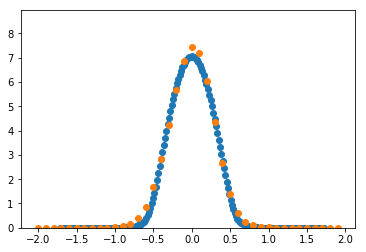

In [26]:
index = 5

xe = x[index][0]
ye = y[index]
yp = model_new.predict(np.array([[xe]]))[0]
print xe

plt.scatter(rs_norm, ye)
plt.scatter(r_new, yp)

plt.ylim(0.000001,1.2*max(yp))
#plt.ylim(0.00000001,0.0004)
#plt.yscale('log')


1.62986062485


(1e-06, 11.445930862426758)

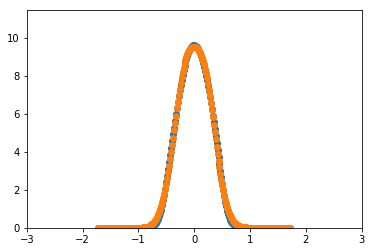

In [305]:
index = 20

xe = x_test[index][0]
ye = y_test[index]
yp = model.predict(np.array([[xe]]))[0]
print xe

#Ae = scaler_x.inverse_transform([[xe]])
#fe = np.exp(xe)*scaler_y.inverse_transform([ye])[0]
#fp = np.exp(xe)*scaler_y.inverse_transform([yp])[0]

plt.scatter(rs_norm, ye)
plt.scatter(rs_norm, yp)

plt.xlim(-3,3)
plt.ylim(0.000001,1.2*max(yp))
#plt.ylim(0.00000001,0.0004)
#plt.yscale('log')


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


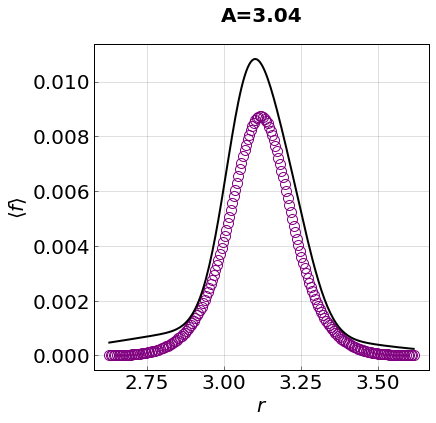

In [123]:
#SELECT TEST DATA
#index = -9
index = 21

xe = x_test[index][0]
ye = y_test[index]
yp = model.predict(np.array([[xe]]))[0]

A = scaler_x.inverse_transform([xe])[0]
r = r_scaler.inverse_transform(rs_norm)

fe = np.exp(ye)-1.0
fp = np.exp(yp)-1.0

plt.plot(r, fe, marker='o', 
         linewidth=0.0, markersize=10, color = 'purple', 
         alpha=2.0, markerfacecolor='None') 

plt.plot(r, fp, marker='o', 
         linewidth=2.0, markersize=0, color = 'black', 
         alpha=2.0, markerfacecolor='None') 

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0.8,0.88)

plt.xlabel(r'$r$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$\langle f \rangle$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('A={}'.format(A), y=1.05, fontdict = title_font)

plt.show()

In [33]:
from keras import backend as K
from keras.layers import Input, Dense, Lambda, concatenate
from keras.models import Model
import numpy as np

class FunctionalFitHelper:

    def InitializeNewModel(self, x_dim, num_cnts, 
                           hidden_dim_rbf, activation_rbf, 
                           hidden_dim_mod, activation_mod):
        
        #initialization details
        self.num_cnts = num_cnts
        self.x_dim = int(x_dim)
        input = Input(shape=(self.x_dim,)) 

        #create a single layer NN for the centers, amplitudes
        #and the exponential factors
        cnt_nns = []
        for i in range(self.num_cnts):
            cnt = Dense(hidden_dim_rbf, activation=activation_rbf)(input)
            cnt = Dense(1, activation='linear')(cnt)
            cnt_nns.append(cnt)

        amp_nns = []
        for i in range(self.num_cnts):
            amp = Dense(hidden_dim_rbf, activation=activation_rbf)(input)
            amp = Dense(1, activation='linear')(amp)
            amp_nns.append(amp)

        efa_nns = []
        for i in range(self.num_cnts):
            efa = Dense(hidden_dim_rbf, activation=activation_rbf)(input)
            efa = Dense(1, activation='linear')(efa)
            efa_nns.append(efa)

        #concatenate the amplitudes and standard deviations
        if num_cnts == 1:
            cnts = cnt_nns[0]
            amps = amp_nns[0]
            efas = efa_nns[0]
        else:
            cnts = concatenate(cnt_nns, axis=-1)
            amps = concatenate(amp_nns, axis=-1)
            efas = concatenate(efa_nns, axis=-1)
            
        #model for each NN for easy access in checkpoint
        self.model_cnts = Model(input, cnts, name='model_cnts')
        self.model_amps = Model(input, amps, name='model_amps')
        self.model_efas = Model(input, efas, name='model_efas')
            
        #create a single layer NN to combine the signals
        #from the various radial basis functions before the final output
        input = Input(shape=(self.num_cnts,))
        rbfs = Dense(hidden_dim_mod, activation=activation_mod)(input)
        rbfs = Dense(1, activation='linear')(rbfs)
        
        #model for the final NN, also for checkpointing
        self.model_rbfs = Model(input, rbfs, name='model_rbfs')

        return None
    
    def InitializeOldModel(self, model):

        #get stored input dimenions
        self.x_dim = self.model_cnts.layers[0].input_shape[1]

        #get the various NNs
        self.model_cnts = model.get_layer('model_cnts')
        self.model_amps = model.get_layer('model_amps')
        self.model_efas = model.get_layer('model_efas')
        self.model_rbfs = model.get_layer('model_rbfs')

        return None
    
    def BuildModel(self, rs):
        #extract relevant dimensions 
        input = Input(shape=(self.x_dim,))

        #input rs
        rs_ = K.variable(value=np.array([rs]))
        rs_ = K.repeat_elements(rs_, rep=self.num_cnts, axis=0)
        num_rs = len(rs)

        #centers, amplitude, and exponential factor NNs
        cnts = self.model_cnts(input)
        amps = self.model_amps(input)
        efas = self.model_efas(input)

        #centers
        cnts_ = Lambda(lambda x: K.expand_dims(x, axis=2), 
                       output_shape=(self.num_cnts,1,))(cnts)
        cnts_ = Lambda(lambda x: K.repeat_elements(x, rep=num_rs, axis=2), 
                       output_shape=(self.num_cnts,num_rs,))(cnts_)

        #amplitudes
        amps_ = Lambda(lambda x: K.expand_dims(x, axis=2), 
                       output_shape=(self.num_cnts,1,))(amps)
        amps_ = Lambda(lambda x: K.repeat_elements(x, rep=num_rs, axis=2), 
                       output_shape=(self.num_cnts,num_rs,))(amps_)

        #exponential factors
        efas_ = Lambda(lambda x: K.expand_dims(x, axis=2), 
                       output_shape=(self.num_cnts,1,))(efas)
        efas_ = Lambda(lambda x: K.repeat_elements(x, rep=num_rs, axis=2), 
                       output_shape=(self.num_cnts,num_rs,))(efas_)

        #custom function implementing the radial basis functions
        def rbfs(rs, input):
            cnts = input[0]
            amps = input[1]
            efas = input[2]
            return K.sum(amps*amps*K.exp(-efas*K.pow(rs-cnts, 2)), axis=1)

        #rbfs wrapped in a lambda layer
        rbfs = Lambda(lambda x: rbfs(rs_, x), name='rbfs', 
                        output_shape=(num_rs,))([cnts_, amps_, efas_])
        

        #custom function to extract the RBF signal data at a single r and flatten
        def ExtractRBFActsAndFlatten(i, input):
            return K.squeeze(input[:,:,i:i+1], axis=2)

        #extract the set of RBF activities for a given r in a flattened form (as row entries)
        rbfs_all = []
        for i in range(num_rs):
            rbfs_single = Lambda(lambda x: ExtractRBFActsAndFlatten(i, x), 
                                         output_shape=(self.num_cnts,))(rbfs) 
            rbfs_all.append(rbfs_single)

        #run each set through the final RBF NN
        rbfs_all_mod = []
        for rbfs_single in rbfs_all:
            rbfs_all_mod.append(self.model_rbfs(rbfs_single))

        #concatenate everything
        output = concatenate(rbfs_all_mod, axis=-1)

        #create the model and return
        return Model(input, output)    

In [1]:
import numpy as np
from keras import backend as K

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [11]:
cnts = np.array([[0.1,0.2,0.3,0.4,0.5,0.6],
                 [0.2,0.3,0.4,0.5,0.6,0.7],
                 [0.3,0.4,0.5,0.6,0.7,0.7]])

num_cnts = len(cnts)

cnts = K.variable(value=cnts)

num_rs = 3

In [12]:
cnts_ = K.expand_dims(cnts, axis=2)
cnts_ = K.repeat_elements(cnts_, rep=num_rs, axis=2)

In [13]:
cnts_.eval()

array([[[ 0.1       ,  0.1       ,  0.1       ],
        [ 0.2       ,  0.2       ,  0.2       ],
        [ 0.30000001,  0.30000001,  0.30000001],
        [ 0.40000001,  0.40000001,  0.40000001],
        [ 0.5       ,  0.5       ,  0.5       ],
        [ 0.60000002,  0.60000002,  0.60000002]],

       [[ 0.2       ,  0.2       ,  0.2       ],
        [ 0.30000001,  0.30000001,  0.30000001],
        [ 0.40000001,  0.40000001,  0.40000001],
        [ 0.5       ,  0.5       ,  0.5       ],
        [ 0.60000002,  0.60000002,  0.60000002],
        [ 0.69999999,  0.69999999,  0.69999999]],

       [[ 0.30000001,  0.30000001,  0.30000001],
        [ 0.40000001,  0.40000001,  0.40000001],
        [ 0.5       ,  0.5       ,  0.5       ],
        [ 0.60000002,  0.60000002,  0.60000002],
        [ 0.69999999,  0.69999999,  0.69999999],
        [ 0.69999999,  0.69999999,  0.69999999]]], dtype=float32)

In [18]:
cnts_1 = cnts_[:,:,0:1]

In [31]:
cnts_1.eval()

array([[[ 0.1       ],
        [ 0.2       ],
        [ 0.30000001],
        [ 0.40000001],
        [ 0.5       ],
        [ 0.60000002]],

       [[ 0.2       ],
        [ 0.30000001],
        [ 0.40000001],
        [ 0.5       ],
        [ 0.60000002],
        [ 0.69999999]],

       [[ 0.30000001],
        [ 0.40000001],
        [ 0.5       ],
        [ 0.60000002],
        [ 0.69999999],
        [ 0.69999999]]], dtype=float32)

In [23]:
K.squeeze(cnts_1, axis=2).eval()

array([[ 0.1       ,  0.2       ,  0.30000001,  0.40000001,  0.5       ,
         0.60000002],
       [ 0.2       ,  0.30000001,  0.40000001,  0.5       ,  0.60000002,
         0.69999999],
       [ 0.30000001,  0.40000001,  0.5       ,  0.60000002,  0.69999999,
         0.69999999]], dtype=float32)

In [28]:
#split up the activities
rbf_acts_at_rs = []
for i in range(num_rs):
    rbf_acts_at_rs.append(   K.squeezerbf_acts[:,:,i:i+1]   )

In [ ]:
####single NN for non-linear combination of RBFs
input = Input(shape=(self.num_cnts,))
rbfmod = Dense(hidden_dim, activation=activation)(input)
rbfmod = Dense(1, activation='linear')(rbfmod)
self.model_rbfmod = Model(input, rbfmod)

In [ ]:
def ExtractRBFActsAndFlatten(i, input):
    return K.squeeze(input[:,:,i:i+1], axis=2)

#extract the set of RBF activities for a given r in a flattened form (as row entries)
rbf_acts_all = []
for i in range(num_rs):
    rbf_acts_single = Lambda(lambda x: ExtractRBFActsAndFlatten(i, x), 
                                 output_shape=(self.num_cnts,))(rbf_acts) 
    rbf_acts_all.append(rbf_acts_single)

#run each set through the final RBF NN
rbf_acts_all_mod = []
for rbf_acts_single in rbf_acts_all:
    rbf_acts_all_mod.append(self.model_rbfmod(rbf_acts_single))

#concatenate everything
output = concatenate(rbf_acts_all_mod, axis=-1)

In [32]:
cnts_.eval()

array([[[ 0.1       ,  0.1       ,  0.1       ],
        [ 0.2       ,  0.2       ,  0.2       ],
        [ 0.30000001,  0.30000001,  0.30000001],
        [ 0.40000001,  0.40000001,  0.40000001],
        [ 0.5       ,  0.5       ,  0.5       ],
        [ 0.60000002,  0.60000002,  0.60000002]],

       [[ 0.2       ,  0.2       ,  0.2       ],
        [ 0.30000001,  0.30000001,  0.30000001],
        [ 0.40000001,  0.40000001,  0.40000001],
        [ 0.5       ,  0.5       ,  0.5       ],
        [ 0.60000002,  0.60000002,  0.60000002],
        [ 0.69999999,  0.69999999,  0.69999999]],

       [[ 0.30000001,  0.30000001,  0.30000001],
        [ 0.40000001,  0.40000001,  0.40000001],
        [ 0.5       ,  0.5       ,  0.5       ],
        [ 0.60000002,  0.60000002,  0.60000002],
        [ 0.69999999,  0.69999999,  0.69999999],
        [ 0.69999999,  0.69999999,  0.69999999]]], dtype=float32)

In [46]:
from keras import backend as K
from keras.layers import Input, Dense, Lambda, concatenate
from keras.models import Model
from keras.constraints import non_neg
import numpy as np

class FunctionalFitHelper:
    
    #build the various NN's used throughout and
    #store as separate models to employ later
    def InitializeNewModel(self, x_dim, num_cnts,
                           hidden_dim_rbf, activation_rbf,
                           hidden_dim_mod, activation_mod):
       
        #initialization details
        self.num_cnts = num_cnts
        self.x_dim = int(x_dim)
        input = Input(shape=(self.x_dim,))

        #create a single layer NN for the centers, amplitudes
        #and the exponential factors
        cnt_nns = []
        for i in range(self.num_cnts):
            cnt = Dense(hidden_dim_rbf, activation=activation_rbf, 
                        kernel_initializer='orthogonal')(input)
            cnt = Dense(1, activation='linear', 
                        kernel_initializer='orthogonal')(cnt)
            cnt_nns.append(cnt)

        amp_nns = []
        for i in range(self.num_cnts):
            amp = Dense(hidden_dim_rbf, activation=activation_rbf, 
                        kernel_initializer='orthogonal')(input)
            amp = Dense(1, activation='linear', 
                        kernel_initializer='orthogonal')(amp)
            amp_nns.append(amp)

        efa_nns = []
        for i in range(self.num_cnts):
            efa = Dense(hidden_dim_rbf, activation=activation_rbf, 
                        kernel_initializer='orthogonal')(input)
            efa = Dense(1, activation='linear', 
                        kernel_initializer='orthogonal')(efa)
            efa_nns.append(efa)

        #concatenate the amplitudes and standard deviations
        if num_cnts == 1:
            cnts = cnt_nns[0]
            amps = amp_nns[0]
            efas = efa_nns[0]
        else:
            cnts = concatenate(cnt_nns, axis=-1)
            amps = concatenate(amp_nns, axis=-1)
            efas = concatenate(efa_nns, axis=-1)
           
        #model for each NN for easy access in checkpoint
        self.model_cnts = Model(input, cnts, name='model_cnts')
        self.model_amps = Model(input, amps, name='model_amps')
        self.model_efas = Model(input, efas, name='model_efas')
        
        
        #use either a single NN to modify the output or a simple summation
        input = Input(shape=(self.num_cnts,))
        
        if hidden_dim_mod is None or activation_mod is None:
            rbfs = Lambda(lambda x: K.sum(x, axis=1, keepdims=True), name='rbfs_sum',
                        output_shape=(1,))(input)
        else:
            rbfs = Dense(hidden_dim_mod, activation=activation_mod)(input)
            rbfs = Dense(1, activation='linear')(rbfs)
       
        #model for the final NN, also for checkpointing
        self.model_rbfs = Model(input, rbfs, name='model_rbfs')

        return None
    
    #read in a saved model for re-instantiation
    def InitializeOldModel(self, 
                           model_cnts, 
                           model_amps, 
                           model_efas, 
                           model_rbfs):
        
        #get the various NNs
        self.model_cnts = model_cnts
        self.model_amps = model_amps
        self.model_efas = model_efas
        self.model_rbfs = model_rbfs

        #get stored input dimenions
        self.x_dim = self.model_cnts.layers[0].input_shape[1]

        return None
   
    #assemble the various NN's within the RBF functional form
    #as well as the final output layer which can be a NN too
    def BuildModel(self, rs):
        #extract relevant dimensions
        input = Input(shape=(self.x_dim,))

        #input rs
        rs_ = K.variable(value=np.array([rs]))
        rs_ = K.repeat_elements(rs_, rep=self.num_cnts, axis=0)
        num_rs = len(rs)

        #centers, amplitude, and exponential factor NNs
        cnts = self.model_cnts(input)
        amps = self.model_amps(input)
        efas = self.model_efas(input)

        #centers
        cnts_ = Lambda(lambda x: K.expand_dims(x, axis=2),
                       output_shape=(self.num_cnts,1,))(cnts)
        cnts_ = Lambda(lambda x: K.repeat_elements(x, rep=num_rs, axis=2),
                       output_shape=(self.num_cnts,num_rs,))(cnts_)

        #amplitudes
        amps_ = Lambda(lambda x: K.expand_dims(x, axis=2),
                       output_shape=(self.num_cnts,1,))(amps)
        amps_ = Lambda(lambda x: K.repeat_elements(x, rep=num_rs, axis=2),
                       output_shape=(self.num_cnts,num_rs,))(amps_)

        #exponential factors
        efas_ = Lambda(lambda x: K.expand_dims(x, axis=2),
                       output_shape=(self.num_cnts,1,))(efas)
        efas_ = Lambda(lambda x: K.repeat_elements(x, rep=num_rs, axis=2),
                       output_shape=(self.num_cnts,num_rs,))(efas_)

        #custom function implementing the radial basis functions
        def rbfs(rs, input):
            cnts = input[0]
            amps = input[1]
            efas = input[2]
            return K.abs(amps)*K.exp(-K.abs(efas)*K.pow(rs-cnts, 2))

        #rbfs wrapped in a lambda layer
        rbfs = Lambda(lambda x: rbfs(rs_, x), name='rbfs',
                        output_shape=(num_rs,))([cnts_, amps_, efas_])
       
        
        #custom function to extract the RBF signal data at a single r and flatten
        def ExtractRBFActsAndFlatten(i, input):
            return K.squeeze(input[:,:,i:i+1], axis=2)

        #extract the set of RBF activities for a given r in 
        #a flattened form (as row entries)
        rbfs_all = []
        for i in range(num_rs):
            rbfs_single = Lambda(lambda x: ExtractRBFActsAndFlatten(i, x),
                                         output_shape=(self.num_cnts,))(rbfs)
            rbfs_all.append(rbfs_single)

        #run each set through the final RBF NN
        rbfs_all_mod = []
        for rbfs_single in rbfs_all:
            rbfs_all_mod.append(self.model_rbfs(rbfs_single))

        #concatenate everything
        output = concatenate(rbfs_all_mod, axis=-1)

        #create the model and return
        return Model(input, output)  

In [2]:
import numpy as np
from keras import backend as K

In [6]:
rc = 4
drc = 0.4
np.arange(-rc, rc+1e-10, drc)

array([ -4.00000000e+00,  -3.60000000e+00,  -3.20000000e+00,
        -2.80000000e+00,  -2.40000000e+00,  -2.00000000e+00,
        -1.60000000e+00,  -1.20000000e+00,  -8.00000000e-01,
        -4.00000000e-01,  -8.88178420e-16,   4.00000000e-01,
         8.00000000e-01,   1.20000000e+00,   1.60000000e+00,
         2.00000000e+00,   2.40000000e+00,   2.80000000e+00,
         3.20000000e+00,   3.60000000e+00,   4.00000000e+00])

In [7]:
5*4*3*2*1

120

In [8]:
20*19

380

In [77]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_12 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
model_cnts (Model)               (None, 10)            610         input_12[0][0]                   
____________________________________________________________________________________________________
model_amps (Model)               (None, 10)            610         input_12[0][0]                   
____________________________________________________________________________________________________
model_efas (Model)               (None, 10)            610         input_12[0][0]                   
___________________________________________________________________________________________

                                                                   model_rbfs[69][0]                
                                                                   model_rbfs[70][0]                
                                                                   model_rbfs[71][0]                
                                                                   model_rbfs[72][0]                
                                                                   model_rbfs[73][0]                
                                                                   model_rbfs[74][0]                
                                                                   model_rbfs[75][0]                
                                                                   model_rbfs[76][0]                
                                                                   model_rbfs[77][0]                
                                                                   model_rbfs[78][0]       